# LGS5145 DCDC Characterize

Using Agilent 34970A with following cards:
* Slot 100: 34901A 20 Channel Multiplexer
* Slot 200: 34907A Multifunction Moudle DIO/Totalize/DAC

Custom DC Load using OpAmp and MOSFET.  
Use DAC to set current load. Step through load sweep at set voltage input.

LGS5145 setup 
* 5V output
* Max input 55V
* Max Current 1000mA

In [1]:
import pyvisa
import time

In [2]:
# Find instrument and connect
rm = pyvisa.ResourceManager()
inst_list = rm.list_resources()
inst = rm.open_resource(inst_list[0], baud_rate=115200) # RS232 connection
inst.timeout = 5000
inst.write("*RST; *CLS")    # reset to power on state, clear status
print(inst.query("*IDN?"))  # get instrument id

HEWLETT-PACKARD,34970A,0,13-2-2



In [3]:
# configure channels
inst.write("configure:voltage:dc 100,DEF,(@101)")   # input voltage, channel 1, 100V range
inst.write("configure:voltage:dc 10,DEF,(@102)")    # output voltage, channel 2, 10V range
inst.write("configure:current:dc 1,DEF,(@121)")     # input current, channel 21, 1A range
inst.write("configure:current:dc 1,DEF,(@122)")     # output current, channel 22, 1A range

35

In [5]:
# configure scanning

''' settings '''
scanIntervals = 10      # Delay in secs, between scans
numberScans = 1         # Number of scan sweeps to measure
channelDelay = 0.1      # Delay, in secs, between relay closure and measurement 
points = 0              # number of data points stored
scanlist = "(@101:102,121:122)"

# setup scan list
inst.write("ROUTE:SCAN " + scanlist)
numberChannels = int(inst.query("ROUTE:SCAN:SIZE?"))
print("number of channels: {}".format(numberChannels))

# reading format
inst.write("FORMAT:READING:CHAN OFF")
inst.write("FORMAT:READING:TIME OFF")

# channel delay
inst.write("ROUT:CHAN:DELAY " + str(channelDelay)+ "," + scanlist)

# setup when scanning starts and interval rate
inst.write("TRIG:COUNT " + str(numberScans)) 
inst.write("TRIG:SOUR TIMER")
inst.write("TRIG:TIMER " + str(scanIntervals))

#start the scan
# inst.write("INIT")  # start scan

number of channels: 4


15

In [19]:
print(inst.query("DATA:POINTS?"))

+0



In [21]:
# Collect data
print("Vin, Vout, Iin, Iout")

for v in range(0, 800):
    inst.write("source:voltage {},(@204)".format(v/100))   # set DAC to voltage
    time.sleep(1) # sleep for 10 seconds
    inst.write("INIT")  # start scan
    time.sleep(1)   # wait for scan

    # read data
    vin_str = inst.query("DATA:REMOVE? 1")
    vout_str = inst.query("DATA:REMOVE? 1")
    iin_str = inst.query("DATA:REMOVE? 1")
    iout_str = inst.query("DATA:REMOVE? 1")

    vin_str = vin_str.replace('\r\n', '')
    vout_str = vout_str.replace('\r\n', '')
    iin_str = iin_str.replace('\r\n', '')
    iout_str = iout_str.replace('\r\n', '')

    # print data
    print("{}, {}, {}, {}".format(vin_str, vout_str, iin_str, iout_str))

# turn off current
inst.write("source:voltage 0,(@204)")   # set DAC to voltage


Vin, Vout, Iin, Iout
+4.50590130E+01, +5.01371900E+00, +1.46600000E-04, -3.93000000E-06
+4.50605790E+01, +5.01647430E+00, +1.41360000E-04, -2.62000000E-06
+4.50608400E+01, +5.02078340E+00, +2.05500000E-04, +4.22780000E-04
+4.50617540E+01, +5.02095320E+00, +3.39010000E-04, +1.44244000E-03
+4.50620150E+01, +5.01990860E+00, +4.98700000E-04, +2.45947000E-03
+4.50582300E+01, +5.01919040E+00, +6.40060000E-04, +3.44771000E-03
+4.50613620E+01, +5.01852440E+00, +7.70960000E-04, +4.48961000E-03
+4.50600570E+01, +5.01787150E+00, +9.11010000E-04, +5.50403000E-03
+4.50580990E+01, +5.01727080E+00, +1.05892000E-03, +6.52368000E-03
+4.50609710E+01, +5.01663100E+00, +1.19767000E-03, +7.52632000E-03
+4.50605790E+01, +5.01610860E+00, +1.34296000E-03, +8.56299000E-03
+4.50611010E+01, +5.01574300E+00, +1.48956000E-03, +9.58787000E-03
+4.50601870E+01, +5.01524680E+00, +1.62830000E-03, +1.05983600E-02
+4.50600570E+01, +5.01459390E+00, +1.77359000E-03, +1.16232500E-02
+4.50604490E+01, +5.01429360E+00, +1.8979

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv("lgs5145_characterize.csv")
df.head()

,Vin,Vout,Iin,Iout
0,45.059013,5.013719,0.000147,-0.000004
1,45.060579,5.016474,0.000141,-0.000003
2,45.060840,5.020783,0.000206,0.000423
3,45.061754,5.020953,0.000339,0.001442
4,45.062015,5.019909,0.000499,0.002459


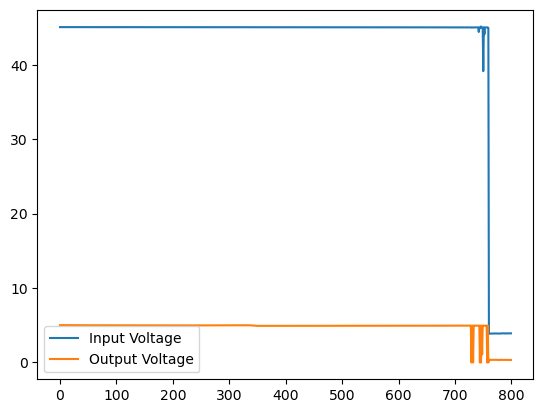

In [25]:
plt.plot(df['Vin'], label = "Input Voltage")
plt.plot(df[' Vout'], label = "Output Voltage")
plt.legend()
plt.show()

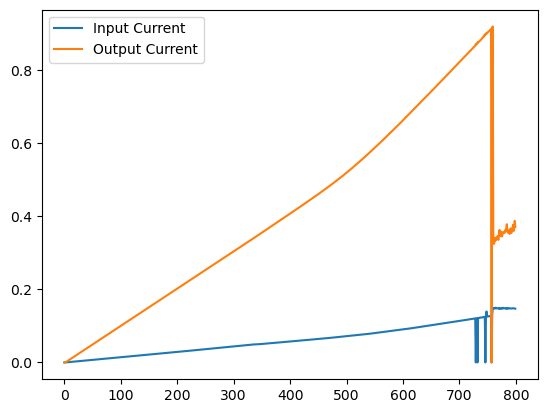

In [26]:
plt.plot(df[" Iin"], label = "Input Current")
plt.plot(df[' Iout'], label = "Output Current")
plt.legend()
plt.show()

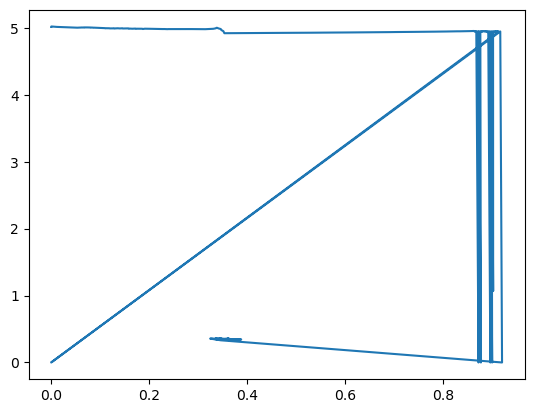

In [27]:
plt.plot(df[' Iout'], df[' Vout'])
plt.show()